In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%aimport src

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

from src.operators import MeasurementOperator, MeasurementOperatorDiscrete
from src.uv_sampling import RadialSampling, SpiderSampling, SpiderSampling2
from src.solvers import l1_constrained_solver, wavelet_basis

imshow_kwargs = {"cmap":'afmhot', "origin":'lower'}

Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [4]:
x_true = fits.getdata("../data/M51.fits")

In [5]:
Nd=(256,256) # input image size 
Kd=(512,512) # oversampled k-space size
Jd=(6,6) # interpolation kernel size

vis = SpiderSampling2() # using Duncan et al. configuration
# vis = RadialSampling(n_bins=120)

op_nufft = MeasurementOperator(vis, Nd, Kd, Jd) # non-uniform
op_discrete = MeasurementOperatorDiscrete(vis, Nd, Kd) # nearest gridpoint

## Point Spread Functions

Text(0.5, 1.0, 'PSF (DFT)')

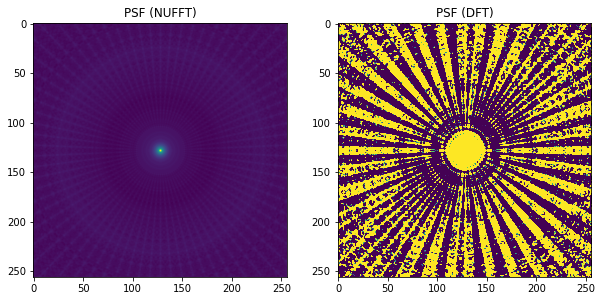

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

psf_nufft = op_nufft.adj_op(np.ones(len(vis))).real
psf_discrete = op_discrete.adj_op(op_discrete.dir_op(x_true)*0 +1)

low_limit = min(np.min(psf_discrete), np.min(psf_nufft))

ax0 = ax[0].imshow(np.log(psf_nufft - low_limit*1.0001))
lim = ax0.get_clim()
ax[1].imshow(np.log(psf_discrete - low_limit*1.0001), vmin=lim[0], vmax=lim[1])

ax[0].set_title("PSF (NUFFT)")
ax[1].set_title("PSF (DFT)")

## Dirty images

Text(0.5, 1.0, 'Dirty image (DFT)')

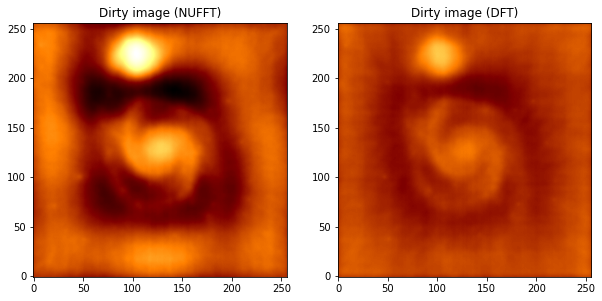

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax0 = ax[0].imshow(op_nufft.self_adj(x_true), **imshow_kwargs)
lim = ax0.get_clim()
ax[1].imshow(op_discrete.self_adj(x_true), vmin=lim[0], vmax=lim[1], **imshow_kwargs)

ax[0].set_title("Dirty image (NUFFT)")
ax[1].set_title("Dirty image (DFT)")


## solving nearest gridpoint case

In [9]:
y = op_discrete.dir_op(x_true) # measurements

result, diag = l1_constrained_solver(y, op_discrete, 10**(-20/20)) 

2021-03-26 14:23:08,862 - Optimus Primal - INFO - Starting Power method
2021-03-26 14:23:08,946 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-03-26 14:23:09,320 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-03-26 14:23:09,666 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2021-03-26 14:23:10,003 - Optimus Primal - INFO - [Power Method] Converged with norm= 0.9722860398622202, iter = 30, tol = 0.0009722770383545212
2021-03-26 14:23:10,125 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-03-26 14:23:10,223 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.000000
2021-03-26 14:23:17,004 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.023936
2021-03-26 14:23:24,001 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.016633
2021-03-26 14:23:31,134 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.016300
2021-03-26 14:

Text(0.5, 1.0, 'Residuals (RMSE:2.5192e+02)')

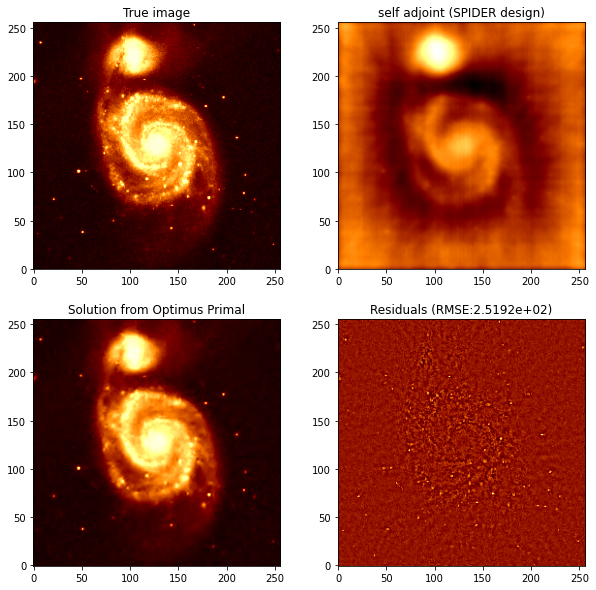

In [10]:

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_discrete.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(result.real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - result.real))):.4e})")


Text(0.5, 0, 'iterations')

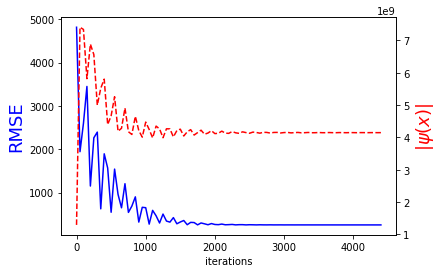

In [11]:
hs = diag['hs']
xs = np.array(diag['xs']) 

rms = [np.sqrt(np.mean(np.square(x_true - xs[i].real))) for i in range(len(xs))]

fig,ax = plt.subplots()
ax.plot(np.arange(0,5000, 50)[:len(rms)], rms, 'b-')
ax.set_ylabel('RMSE', color='b', fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.arange(0,5000, 50)[:len(rms)], hs, 'r--')
ax2.set_ylabel(r"$|\psi(x)|$", color='r', fontsize=18)
ax.set_xlabel('iterations')

Text(0.5, 1.0, 'Residuals (RMSE:2.5191e+02)')

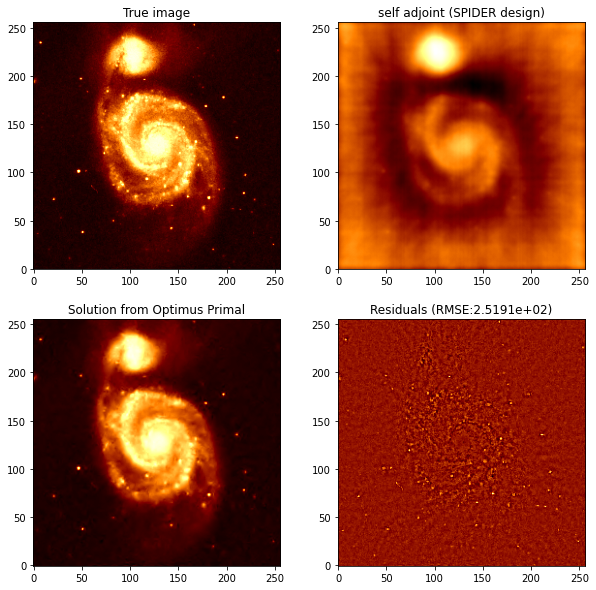

In [12]:
i=np.argmin(rms)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_discrete.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(xs[i].real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - xs[i].real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - xs[i].real))):.4e})")

## solving non-uniform case

In [13]:
y = op_nufft.dir_op(x_true) # measurements
result2, diag2 = l1_constrained_solver(y, op_nufft, 10**(-20/20)) 

2021-03-26 14:33:39,503 - Optimus Primal - INFO - Starting Power method
2021-03-26 14:33:39,559 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-03-26 14:33:39,785 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-03-26 14:33:40,006 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2021-03-26 14:33:40,128 - Optimus Primal - INFO - [Power Method] Converged with norm= 2.868377, iter = 27, tol = 0.00096770056
2021-03-26 14:33:40,219 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-03-26 14:33:40,328 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.000000
2021-03-26 14:33:45,896 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.016217
2021-03-26 14:33:51,311 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.015820
2021-03-26 14:33:56,720 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.009716
2021-03-26 14:34:02,137 - Optimu

Text(0.5, 1.0, 'Residuals (RMSE:1.4373e+03)')

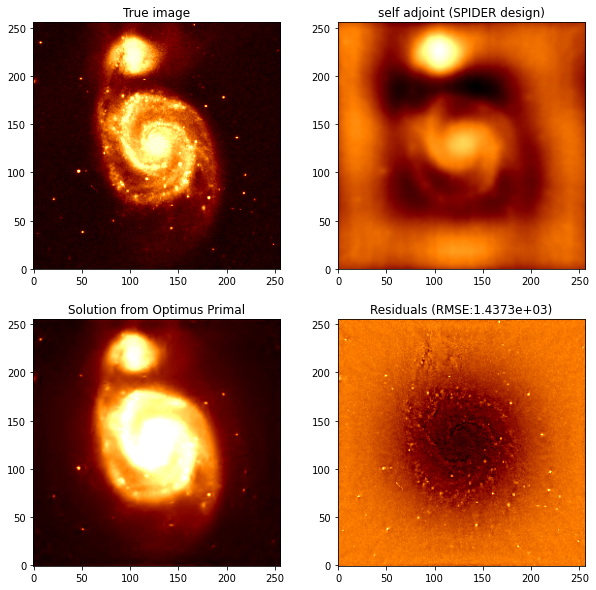

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(result2.real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result2.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - result2.real))):.4e})")


Text(0.5, 0, 'iterations')

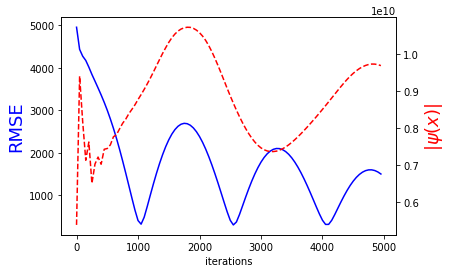

In [16]:
hs = diag2['hs']
xs = np.array(diag2['xs']) 

rms = [np.sqrt(np.mean(np.square(x_true - xs[i].real))) for i in range(len(xs))]

fig,ax = plt.subplots()
ax.plot(np.arange(0,5000, 50)[:len(rms)], rms, 'b-')
ax.set_ylabel('RMSE', color='b', fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.arange(0,5000, 50)[:len(rms)], hs, 'r--')
ax2.set_ylabel(r"$|\psi(x)|$", color='r', fontsize=18)
ax.set_xlabel('iterations')

Text(0.5, 1.0, 'Residuals (RMSE:3.0162e+02)')

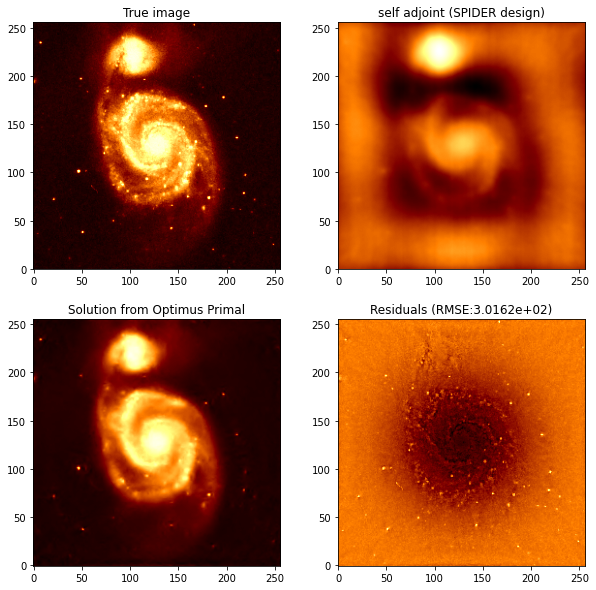

In [17]:
i=np.argmin(rms)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(xs[i].real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result2.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - xs[i].real))):.4e})")